In [1]:
"""
Numerical testing of the analytically derived integral
"""

import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.integrate as integrate
from scipy.special import erf
import seaborn as sns

import matplotlib.colors as mcolors

In [2]:
levs=201
cmap = mcolors.LinearSegmentedColormap.from_list(name='red_white_blue', 
                                                 colors =[(0, 0, 1), 
                                                          (1, 1, 1), 
                                                          (1, 0, 0)],
                                                 N=levs-1,
                                                 )

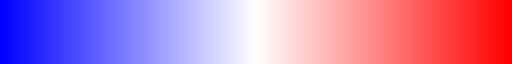

In [3]:
cmap

In [4]:
def relative_error():
    
    Generator = np.random.default_rng()
    df = [np.nan*np.zeros(21 * 20), np.nan*np.zeros(21 * 20), np.nan*np.zeros(21 * 20)]
    for n, offset_value in enumerate(np.linspace(-10, 10, 21)):
        df[0][n * 20:(n + 1) * 20] = offset_value
    scale_values = [0.5 + n / 10 for n in range(1, 21)]
    for n, value in enumerate(df[1]):
        df[1][n] = scale_values[n % 20]

    for i, value in enumerate(df[2]):
        
        offset = df[0][i]
        scale = df[1][i]
        
        data = []
        for n in range(len(observable)):
            data.append(Generator.laplace(offset + n + 1, scale))
        
        data = np.asarray(data)

        analytical = analytical_laplace(data, scale)
        numerical = numerical_marginalisation_offset(data, scale)
        
        eps = 1e-6
        relative_error = abs(numerical-analytical)/abs(analytical+eps)
        
        df[2][i] = relative_error
        
        if np.isnan(relative_error):
            print(list(data))
            print(scale)
            break

    _df = pd.DataFrame({'offset': df[0], 'scale': df[1], 'relative_error': df[2]})
    pivot = _df.pivot(index='offset', columns='scale', values='relative_error')
    
    _abs_limit=max([abs(_df.relative_error.max()), abs(_df.relative_error.min())])
    
    abs_limit=max([1, _abs_limit])
    
    plt.figure(figsize=(13, 10))
    ax = sns.heatmap(pivot, cmap=cmap, linewidths=.5,
                     cbar_kws={'label': 'relative error'}, vmin=-abs_limit, vmax=abs_limit
                    )
    # plt.savefig(fname=d + '\\plots\\relative_error_gaussian_noise.png')
    plt.show()
    
    return _df

In [5]:
def gaussian_prior(offset, _tau = 1.5, mu = 1.5):
    """ Prior function."""

    tau = 1/_tau**2
    
    #Gaussian prior
    Gauss_prior = np.sqrt(tau/(2*np.pi))*np.exp(-0.5*tau*(offset - mu)**2)

    return Gauss_prior


def log_likelihood(offset, scale, data):
    """ Log likelihood function."""

    N = len(data)

    simulation = offset + observable

    # evaluate standard log likelihood
    res = abs(data - simulation)
    sum_res = np.sum(res) / scale

    l_llh = N*(- np.log(2) -np.log(scale)) - sum_res

    # return log posterior
    return l_llh


def evaluate_posterior_standard(offset, scale, data):
    
    # evaluate likelihood
    likelihood = np.exp(log_likelihood(offset, scale, data))
    
    # evaluate prior
    prior = gaussian_prior(offset)
    
    # return posterior
    return likelihood*prior


def numerical_marginalisation_offset(data, scale):
    marginal_posterior, _ = integrate.quad(evaluate_posterior_standard, -np.inf, np.inf, args=(scale, data))

    return -np.log(marginal_posterior)

In [6]:
def _evaluate_integral0(offset,scale,b_vector):
    """ Negative log posterior function."""

    # evaluate standard log likelihood
    res = abs(offset - b_vector)
    sum_res = np.exp(-np.sum(res) / scale)

    # evaluate log normal-gamma prior
    prior = gaussian_prior(offset)

    # return log posterior
    return sum_res * prior

def _numerical_marginalisation_offset0(data, scale):
    
    N = len(data)
    simulation = observable
    
    # evaluate standard log likelihood
    res = data - simulation
    b_vector = np.sort(res)
    
    bounds = np.append(np.append(-np.inf, b_vector), np.inf)
    
    marginal_posterior = 0
    for i in range(len(bounds)-1):
        _marginal_posterior, _ = integrate.quad(_evaluate_integral0, 
                                                bounds[i], bounds[i+1], 
                                                args=(scale, b_vector))

        marginal_posterior += _marginal_posterior
    
    log_marginal_posterior = np.log(marginal_posterior)
    log_marginal_posterior += -N*(np.log(2) + np.log(scale))
    
    return -log_marginal_posterior

In [7]:
def _evaluate_integral1(offset,scale,N,i):
    """ Negative log posterior function."""

    l_llh = offset*(N-2*i)/scale

    # evaluate log normal-gamma prior
    prior = gaussian_prior(offset)

    # return log posterior
    return np.exp(l_llh) * prior

def _numerical_marginalisation_offset1(data, scale):
    
    N = len(data)
    simulation = observable
    
    # evaluate standard log likelihood
    res = data - simulation
    b_vector = np.sort(res)
    
    bounds = np.append(np.append(-np.inf, b_vector), np.inf)
    
    marginal_posterior = 0
    for i in range(len(bounds)-1):
        _marginal_posterior, _ = integrate.quad(_evaluate_integral1, 
                                                bounds[i], bounds[i+1], 
                                                args=(scale, N, i))
        
        if _marginal_posterior == 0:
            continue  # to avoid numerical overflow
        else:
            l_i = np.sum(b_vector[:i]) - np.sum(b_vector[i:])
            marginal_posterior += _marginal_posterior*np.exp(l_i/scale)

    
    log_marginal_posterior = np.log(marginal_posterior)
    log_marginal_posterior += -N*(np.log(2) + np.log(scale))
    
    return -log_marginal_posterior

In [8]:
def _evaluate_integral2(offset,scale,aux, _tau = 1.5, mu = 1.5):
    """ Negative log posterior function."""
    
    tau = 1/_tau**2
    
    l_llh = -0.5*tau*(offset - (aux/(tau*scale)+mu))**2

    # return log posterior
    return np.exp(l_llh)

def _numerical_marginalisation_offset2(data, scale, _tau = 1.5, mu = 1.5):
    
    tau = 1/_tau**2
    
    N = len(data)
    simulation = observable
    
    # evaluate standard log likelihood
    res = data - simulation
    b_vector = np.sort(res)
    
    bounds = np.append(np.append(-np.inf, b_vector), np.inf)
    
    marginal_posterior = 0
    for i in range(len(bounds)-1):
        
        aux = N-2*i
        
        _marginal_posterior, _ = integrate.quad(_evaluate_integral2, 
                                                bounds[i], bounds[i+1], 
                                                args=(scale, aux))
        
        if _marginal_posterior == 0:
            continue  # to avoid numerical overflow
        else:
            l_i = np.sum(b_vector[:i]) - np.sum(b_vector[i:])
            _aux = aux**2/(2*tau*scale**2)+mu*aux/scale
            
            marginal_posterior += np.exp(np.log(_marginal_posterior)+l_i/scale+_aux)
    
    log_marginal_posterior = np.log(marginal_posterior)
    log_marginal_posterior += -(N+0.5)*np.log(2) - N*np.log(scale) + 0.5*np.log(tau) - 0.5*np.log(np.pi)
    
    return -log_marginal_posterior

In [9]:
def _evaluate_integral3(z):
    return np.exp(-z**2)

def _numerical_marginalisation_offset3(data, scale, _tau = 1.5, mu = 1.5):
    
    tau = 1/_tau**2
    
    N = len(data)
    simulation = observable
    
    # evaluate standard log likelihood
    res = data - simulation
    b_vector = np.sort(res)
    
    bounds = np.append(np.append(-np.inf, b_vector), np.inf)
    
    marginal_posterior = 0
    for i in range(len(bounds)-1):
        
        aux = N-2*i
        
        _marginal_posterior, _ = integrate.quad(_evaluate_integral3, 
                                                _substitution_function(bounds[i], scale, aux, tau, mu),
                                                _substitution_function(bounds[i+1], scale, aux, tau, mu)
                                               )
        
        if _marginal_posterior == 0:
            continue  # to avoid numerical overflow
        else:
            l_i = np.sum(b_vector[:i]) - np.sum(b_vector[i:])
            _aux = aux**2/(2*tau*scale**2)+mu*aux/scale
            
            marginal_posterior += np.exp(np.log(_marginal_posterior)+l_i/scale+_aux)
            
    log_marginal_posterior = np.log(marginal_posterior)
    log_marginal_posterior += -(N+0.5)*np.log(2) - N*np.log(scale) + 0.5*np.log(tau) - 0.5*np.log(np.pi)
    
    return -log_marginal_posterior

In [10]:
def _substitution_function(z, scale, aux, tau, mu):
    return (z - aux / (tau * scale) - mu) / np.sqrt(2 / tau)

In [11]:
def evaluate_k(element_1, element_2, n_case):
    if n_case == 1:
        return erf(-element_1)-erf(-element_2)
    elif n_case == 2:
        return erf(-element_1)+erf(element_2)
    elif n_case == 3:
        return -erf(element_1)+erf(element_2)


def analytical_laplace(data, scale, _tau = 1.5, mu = 1.5):
    
    tau = 1/_tau**2
    
    N = len(data)
    simulation = observable
    
    # evaluate standard log likelihood
    res = data - simulation
    b_vector = np.sort(res)
    
    bounds = np.append(np.append(-np.inf, b_vector), np.inf)
    
    marginal_posterior = 0
    for i in range(len(bounds)-1):
        
        aux = N-2*i

        element_1 = _substitution_function(bounds[i], scale, 
                                           aux, tau, mu)
        element_2 = _substitution_function(bounds[i+1], scale, 
                                           aux, tau, mu)
        
        if element_1 <= element_2 <= 0:
            n_case = 1
        elif element_1 <= 0 <= element_2:
            n_case = 2
        elif 0 <= element_1 <= element_2:
            n_case = 3
        
        k_i = evaluate_k(element_1, element_2, n_case)
        
        if k_i == 0:
            continue  # to avoid numerical overflow
        
        else:
            l_i = np.sum(b_vector[:i]) - np.sum(b_vector[i:])
            _aux = aux**2/(2*tau*scale**2)+mu*aux/scale

            marginal_posterior += k_i*np.exp(l_i/scale+_aux)
    
    log_marginal_posterior = np.log(marginal_posterior)
    log_marginal_posterior += -(N + 1)*np.log(2) - N*np.log(scale)
    
    return -log_marginal_posterior

In [12]:
observable = np.array(range(1, 16))

In [13]:
data = np.array([-8.734234535804228, -8.070241412626324, -7.258959850611621, 
                 -5.630231801619782, -5.337659957698826, -4.742431451006856, 
                 -3.7248998999705885, -1.6375239224105091, -1.023813949817059, 
                 -1.7258526076783034, 1.017255609480662, 2.3401348870036496, 
                 2.5754785066602897, 5.066078669337017, 5.0221409469957115])

scale = 0.6

In [14]:
numerical_marginalisation_offset(data, scale)

62.1542043402912

In [15]:
_numerical_marginalisation_offset0(data, scale)

45.69075574631228

In [16]:
_numerical_marginalisation_offset1(data, scale)

45.6907557463123

In [17]:
_numerical_marginalisation_offset2(data, scale)

45.690756862217356

In [18]:
_numerical_marginalisation_offset3(data, scale)

46.442795560605504

In [19]:
analytical_laplace(data, scale)

46.19662017158599

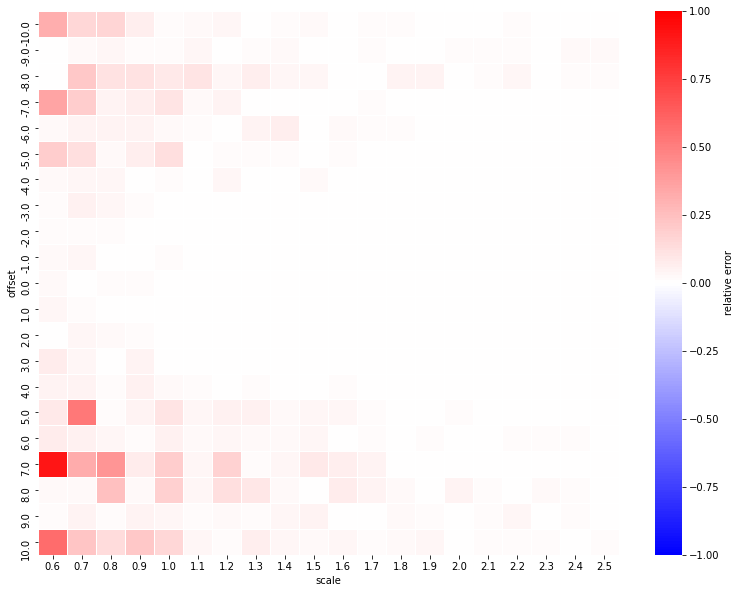

In [20]:
df = relative_error()

In [21]:
np.where(np.isnan(df.relative_error))

(array([], dtype=int64),)

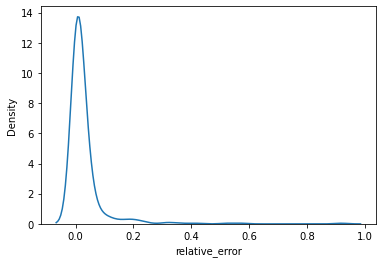

In [22]:
sns.kdeplot(df.relative_error)
# plt.xlim([-1,1])
plt.show()